In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
# --- CELDA DE PREPARACIÓN DE DATOS (VERSIÓN FINAL) ---
import pandas as pd
import numpy as np

# 1. Cargar los DOS únicos archivos que importan
df_ventas = pd.read_csv("ventas_con_features.csv")
pr = pd.read_csv("productos_2025.csv")

# 2. Procesar Productos (Rotacion)
print("Procesando 'productos_2025' (pr)...")
rotacion_map = {'alta': 3, 'media': 2, 'baja': 1}
pr['Rotacion_Cod'] = pr['Rotacion'].map(rotacion_map)
pr_features = pr[['SKU', 'Precio_base', 'Rotacion_Cod']]

# 3. Procesar Ventas (Agregación Quincenal)
print("Procesando 'ventas_con_features.csv'...")
df_ventas['Fecha'] = pd.to_datetime(df_ventas['Fecha'])
df_ventas.set_index('Fecha', inplace=True)

print("Agrupando transacciones por SKU y Quincena (2W)...")
df_agregado = df_ventas.groupby('SKU').resample('2W').agg(
    # Agregamos las features numéricas que nos importan
    Demanda_Total=('Cantidad_item', 'sum'),
    Precio_Prom_Venta=('Precio_unidad', 'mean'), # <-- AQUÍ CREAMOS la columna
    Num_Transacciones=('Num_Boleta', 'nunique'),
    Num_Feriados=('dia_festivo', 'sum'),
    Num_Dias_Pago=('quincena_pago', 'sum'),
    Num_Dias_Promocion=('dia_promocion', 'sum')
).fillna(0)
df_agregado.reset_index(inplace=True)

# 4. Unir (Merge)
print("Uniendo datos quincenales con datos de productos...")
df_enriquecido = pd.merge(
    df_agregado, 
    pr_features, 
    on='SKU', 
    how='left'
)

# 5. Crear Target
df_enriquecido['Target_Demanda_Futura'] = df_enriquecido.groupby('SKU')['Demanda_Total'].shift(-1)
df_final_2 = df_enriquecido.dropna(subset=['Target_Demanda_Futura'])
df_final_2.fillna(0, inplace=True)

print("\n--- ¡'df_final' creado correctamente! ---")
df_final_2.head()

Procesando 'productos_2025' (pr)...
Procesando 'ventas_con_features.csv'...
Agrupando transacciones por SKU y Quincena (2W)...
Uniendo datos quincenales con datos de productos...

--- ¡'df_final' creado correctamente! ---


C:\Users\agabr\AppData\Local\Temp\ipykernel_31768\3224938831.py:21: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agregado = df_ventas.groupby('SKU').resample('2W').agg(
C:\Users\agabr\AppData\Local\Temp\ipykernel_31768\3224938831.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2.fillna(0, inplace=True)


,SKU,Fecha,Demanda_Total,Precio_Prom_Venta,Num_Transacciones,Num_Feriados,Num_Dias_Pago,Num_Dias_Promocion,Precio_base,Rotacion_Cod,Target_Demanda_Futura
0,SKU-0001,2025-01-05,48,9.962500,16,0,0,0,10.0,3,109.0
1,SKU-0001,2025-01-19,109,9.852632,38,0,0,0,10.0,3,131.0
2,SKU-0001,2025-02-02,131,9.649057,53,0,5,0,10.0,3,102.0
3,SKU-0001,2025-02-16,102,9.454054,37,0,3,2,10.0,3,126.0
4,SKU-0001,2025-03-02,126,9.289583,48,0,5,0,10.0,3,115.0


SET VALORES

In [16]:
FEATURES = [
    'Demanda_Total', 
    'Precio_Prom_Venta', # <-- El nombre que creamos en la agregación
    'Num_Transacciones', 
    'Precio_base', 
    'Rotacion_Cod',
    'Num_Feriados',
    'Num_Dias_Pago',
    'Num_Dias_Promocion'
]

TARGET = 'Target_Demanda_Futura'

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

df_scaled = df_final_2.copy()

df_scaled[FEATURES] = scaler_x.fit_transform(df_final_2[FEATURES])

df_scaled[TARGET] = scaler_y.fit_transform(df_final_2[[TARGET]])

print("Datos escalados (normalizados entre 0 y 1).")

Datos escalados (normalizados entre 0 y 1).


In [17]:
#print("Creando secuencias 3D (ventanas de tiempo)...")

# Usaremos 5 quincenas pasadas para predecir la 6ta.
TIME_STEPS = 5 

def create_sequences(data, features, target, time_steps):
    X_seq, Y_seq = [], []
    
   
    for sku, group in data.groupby('SKU'):
        
        feature_data = group[features].values
        target_data = group[target].values
        
       
        for i in range(len(group) - time_steps):
            
            X_sample = feature_data[i : (i + time_steps)]
           
            Y_sample = target_data[i + time_steps]
            
            X_seq.append(X_sample)
            Y_seq.append(Y_sample)
            
    return np.array(X_seq), np.array(Y_seq)

X, Y = create_sequences(df_scaled, FEATURES, TARGET, TIME_STEPS)

print(f"Secuenciación completa. Se crearon {len(X)} muestras.")

Secuenciación completa. Se crearon 19129 muestras.


In [18]:
#print("Dividiendo en sets de Entrenamiento, Validación y Prueba...")

total_samples = len(X)
train_size = int(total_samples * 0.70)
val_size = int(total_samples * 0.15)
# El resto es 'test_size'

# División secuencial
X_train, Y_train = X[0:train_size], Y[0:train_size]
X_val, Y_val = X[train_size : train_size + val_size], Y[train_size : train_size + val_size]
X_test, Y_test = X[train_size + val_size :], Y[train_size + val_size :]

print("\n--- ¡Preparación de Datos Completada! ---")
print("Formatos (shapes) de los datos listos para el GRU:")
print(f"X_train (Muestras, Pasos_Tiempo, Features): {X_train.shape}")
print(f"Y_train (Muestras):                       {Y_train.shape}")
print(f"X_val:                                    {X_val.shape}")
print(f"Y_val:                                    {Y_val.shape}")
print(f"X_test:                                   {X_test.shape}")
print(f"Y_test:                                   {Y_test.shape}")

print("\nScalers 'scaler_x' y 'scaler_y' están listos en memoria.")


--- ¡Preparación de Datos Completada! ---
Formatos (shapes) de los datos listos para el GRU:
X_train (Muestras, Pasos_Tiempo, Features): (13390, 5, 8)
Y_train (Muestras):                       (13390,)
X_val:                                    (2869, 5, 8)
Y_val:                                    (2869,)
X_test:                                   (2870, 5, 8)
Y_test:                                   (2870,)

Scalers 'scaler_x' y 'scaler_y' están listos en memoria.


In [19]:
X_train_tensor = torch.tensor(X_train).float()
Y_train_tensor = torch.tensor(Y_train).float()

X_val_tensor = torch.tensor(X_val).float()
Y_val_tensor = torch.tensor(Y_val).float()

X_test_tensor = torch.tensor(X_test).float()
Y_test_tensor = torch.tensor(Y_test).float()

In [20]:
Y_train_tensor = Y_train_tensor.unsqueeze(1)
Y_val_tensor = Y_val_tensor.unsqueeze(1)
Y_test_tensor = Y_test_tensor.unsqueeze(1)

In [21]:
batch_size = 64

In [22]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders listos. Tamaño del lote (batch_size): {batch_size}")

DataLoaders listos. Tamaño del lote (batch_size): 64


GRU

In [23]:
import random

SEED = 42 # Empezaremos con 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"Semilla aleatoria fijada en: {SEED}")

Semilla aleatoria fijada en: 42


In [24]:
class GRUModel(nn.Module):
    
    # Añadimos 'dropout_prob'
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True,
                          dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [25]:
#Hiperparametros
INPUT_SIZE = X_train_tensor.shape[2] 
OUTPUT_SIZE = 1 
HIDDEN_SIZE = 128
NUM_LAYERS = 3
LEARNING_RATE = 0.0003
NUM_EPOCHS = 500 
CLIP_VALUE = 1.0 # (Para Gradient Clipping)
DROPOUT_PROB = 0.5 # (50% de apagado aleatorio)
PATIENCE = 20 

MODEL_PATH = f"GRU_CAMPEON_seed{SEED}_lr{LEARNING_RATE}.pth"

model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_PROB)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Iniciando entrenamiento con {NUM_EPOCHS} épocas (Paciencia={PATIENCE})...")

history_loss = []
history_val_loss = []
history_r2_score = [] 

best_val_loss = float('inf') 
patience_counter = 0
best_model_weights = None 

for epoch in range(NUM_EPOCHS):
    
    #Entrenamiento
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        optimizer.step()
        epoch_train_loss += loss.item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    history_loss.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0.0

    all_y_val = []
    all_outputs_val = []
    
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_Y_val)
            epoch_val_loss += loss_val.item()
            
            # Guardamos los tensores (en CPU) para el R²
            all_y_val.append(batch_Y_val.cpu())
            all_outputs_val.append(outputs_val.cpu())
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    history_val_loss.append(avg_val_loss)
    
    # Concatenamos todos los lotes de validación
    all_y_val = torch.cat(all_y_val).numpy()
    all_outputs_val = torch.cat(all_outputs_val).numpy()
    
    # Calculamos R²
    r2 = r2_score(all_y_val, all_outputs_val)
    history_r2_score.append(r2)
    
    # Imprimir el progreso
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss(Train): {avg_train_loss:.5f}, Loss(Val): {avg_val_loss:.5f}, R² (Val): {r2:.4f}")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"   -> Mejorado. Guardando modelo...")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"\n¡Early Stopping activado en la época {epoch+1}!")
        print(f"La pérdida de validación no mejoró por {PATIENCE} épocas.")
        break 

if best_model_weights:
    print("Cargando pesos del mejor modelo guardado.")
    model.load_state_dict(best_model_weights)

print("Entrenamiento completado.")

#GUARDAR EL MEJOR MODELO
if best_model_weights:
    torch.save(best_model_weights, MODEL_PATH)
    print(f"\n¡Modelo campeón GUARDADO EN DISCO! -> {MODEL_PATH}")
else:
    print("\nError: No se guardó ningún modelo.")

Iniciando entrenamiento con 500 épocas (Paciencia=20)...
Epoch [1/500], Loss(Train): 0.00124, Loss(Val): 0.00043, R² (Val): -0.0412
   -> Mejorado. Guardando modelo...
Epoch [2/500], Loss(Train): 0.00053, Loss(Val): 0.00037, R² (Val): 0.1227
   -> Mejorado. Guardando modelo...
Epoch [3/500], Loss(Train): 0.00052, Loss(Val): 0.00038, R² (Val): 0.0853
Epoch [4/500], Loss(Train): 0.00048, Loss(Val): 0.00036, R² (Val): 0.1273
   -> Mejorado. Guardando modelo...
Epoch [5/500], Loss(Train): 0.00049, Loss(Val): 0.00039, R² (Val): 0.0643
Epoch [6/500], Loss(Train): 0.00049, Loss(Val): 0.00037, R² (Val): 0.1122
Epoch [7/500], Loss(Train): 0.00046, Loss(Val): 0.00037, R² (Val): 0.1176
Epoch [8/500], Loss(Train): 0.00045, Loss(Val): 0.00036, R² (Val): 0.1358
   -> Mejorado. Guardando modelo...
Epoch [9/500], Loss(Train): 0.00042, Loss(Val): 0.00037, R² (Val): 0.1218
Epoch [10/500], Loss(Train): 0.00045, Loss(Val): 0.00036, R² (Val): 0.1313
Epoch [11/500], Loss(Train): 0.00043, Loss(Val): 0.00036,

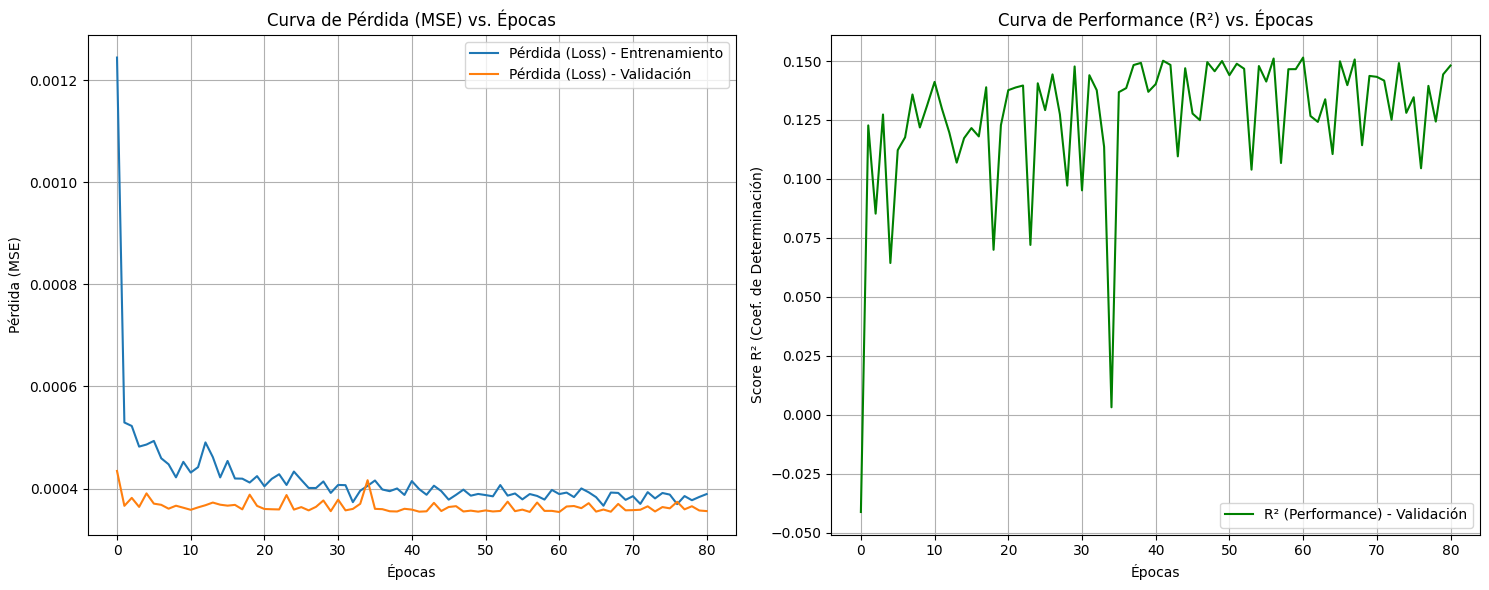

In [26]:
plt.figure(figsize=(15, 6))

#(MSE)
plt.subplot(1, 2, 1) 
plt.plot(history_loss, label='Pérdida (Loss) - Entrenamiento')
plt.plot(history_val_loss, label='Pérdida (Loss) - Validación')
plt.title('Curva de Pérdida (MSE) vs. Épocas')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(True)

# Curva de Performance
plt.subplot(1, 2, 2) 
plt.plot(history_r2_score, label='R² (Performance) - Validación', color='green')
plt.title('Curva de Performance (R²) vs. Épocas')
plt.ylabel('Score R² (Coef. de Determinación)')
plt.xlabel('Épocas')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout() 
plt.show()

VERIFICACION DE MEJORES MODELOS


Métricas Finales del Modelo
  Score R² (Test):     0.2320
  Error (MAE Test):    2.7552 (Unidades de Demanda)
  Error (RMSE Test):   3.6055 (Unidades de Demanda)

El MAE significa que, en promedio, las predicciones del modelo
se desvían en 2.76 unidades de la demanda real.


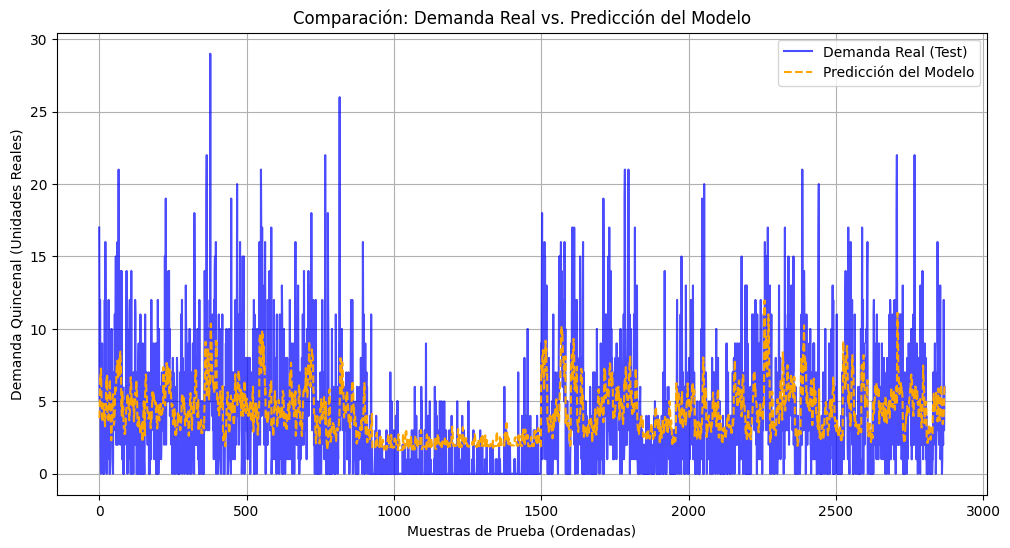

In [27]:
model.eval() 

all_y_test = []
all_outputs_test = []

with torch.no_grad(): 
    for batch_X_test, batch_Y_test in test_loader:
        outputs_test = model(batch_X_test)
        
        
        all_y_test.append(batch_Y_test.cpu())
        all_outputs_test.append(outputs_test.cpu())

all_y_test = torch.cat(all_y_test).numpy()
all_outputs_test = torch.cat(all_outputs_test).numpy()

y_test_real = scaler_y.inverse_transform(all_y_test)
y_pred_real = scaler_y.inverse_transform(all_outputs_test)

test_mse = mean_squared_error(y_test_real, y_pred_real)
test_rmse = np.sqrt(test_mse) 
test_mae = mean_absolute_error(y_test_real, y_pred_real)
test_r2 = r2_score(y_test_real, y_pred_real)

print("\nMétricas Finales del Modelo")
print(f"  Score R² (Test):     {test_r2:.4f}")
print(f"  Error (MAE Test):    {test_mae:.4f} (Unidades de Demanda)")
print(f"  Error (RMSE Test):   {test_rmse:.4f} (Unidades de Demanda)")
print("\nEl MAE significa que, en promedio, las predicciones del modelo")
print(f"se desvían en {test_mae:.2f} unidades de la demanda real.")

plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Demanda Real (Test)', color='blue', alpha=0.7)
plt.plot(y_pred_real, label='Predicción del Modelo', color='orange', linestyle='--')
plt.title('Comparación: Demanda Real vs. Predicción del Modelo')
plt.ylabel('Demanda Quincenal (Unidades Reales)')
plt.xlabel('Muestras de Prueba (Ordenadas)')
plt.legend()
plt.grid(True)
plt.show()